In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from shGLM_class import shGLM
from sklearn import metrics

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
syn_T = 351
C_den = torch.tensor([0,1,1,1,1])
sub_no = C_den.shape[0]

batch_size = 1250

syn_basis_no = 2
hist_basis_no = 3
spike_status = False
hist_T = 251


In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
N = torch.sum(Ensyn) + torch.sum(Insyn)
print(N)

C_syn = torch.zeros(sub_no, N)
count = 0
for m in range(sub_no):
    for e in range(Ensyn[m]):
        C_syn[m,count] = 1
        count += 1
        
for m in range(sub_no):
    for i in range(Insyn[m]):
        C_syn[m,count] = -1
        count += 1

tensor(749)


# Train ALL Params

In [4]:
fit_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T)
fit_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/final_fit/final5_nospike_s2_h3_shglm_i13000.pt"))


V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
#adjust_K_hist = torch.ones(sub_no, hist_basis_tau.shape[0])*(-0.05)
#adjust_thresh = torch.ones(sub_no)*13
#adjust_spike_size = torch.ones(sub_no)*20
#adjust_thresh_scale = torch.ones(sub_no)*10
adjust_K_hist = torch.ones(sub_no, hist_basis_no)*(0.05)
adjust_thresh = torch.ones(sub_no)*7
adjust_spike_size = torch.ones(sub_no)*5
adjust_thresh_scale = torch.ones(sub_no)*5

with torch.no_grad():
    fit_shGLM.K_hist = nn.Parameter(adjust_K_hist.float(), requires_grad=True)
    fit_shGLM.thresh = nn.Parameter(adjust_thresh.float(), requires_grad=True)
    fit_shGLM.spike_size = nn.Parameter(adjust_spike_size, requires_grad=True)
    fit_shGLM.thresh_scale = nn.Parameter(adjust_thresh_scale, requires_grad=True)
    
fit_shGLM.cuda()

shGLM()

In [6]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

37500
37500


In [8]:
no_spike_bool = True
spike_bool = True

fit_shGLM.V_o.requires_grad = no_spike_bool
fit_shGLM.K_syn.requires_grad = no_spike_bool
fit_shGLM.Delta.requires_grad = no_spike_bool
fit_shGLM.C.requires_grad= no_spike_bool
fit_shGLM.Theta.requires_grad = no_spike_bool

fit_shGLM.thresh.requires_grad = spike_bool
fit_shGLM.spike_size.requires_grad = spike_bool
fit_shGLM.K_hist.requires_grad = spike_bool
fit_shGLM.thresh_scale.requires_grad = spike_bool


In [9]:
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.01)
optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.005)
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.0005)

In [10]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    fit_shGLM.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_shGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
    
    #loss = criterion(batch_ref, batch_pred)
    
    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    loss_array[i] = loss.item()
    
    #print(i, train_score)
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        fit_shGLM.eval()
        test_pred = fit_shGLM(test_neural.float())
        #test_loss = criterion(test_V_ref, test_pred)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score, train_score)
        if i%100 == 0:
            torch.save(fit_shGLM.state_dict(), "/media/hdd01/sklee/shglm/biophysical/final_fit/final5_spike5_s2_h3_shglm_i"+str(i)+".pt")
    


<ipython-input-10-de418ef925ef>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 4.4092770882851395 0.6807488303549138 0.3505600140583033
TEST 100 2.184115911426717 0.8418603447149899 0.7401135457709278
TEST 200 3.278233301917004 0.7626414047146679 0.5656171911336483
TEST 300 2.459141994473518 0.821947239451679 0.7482402773243342
TEST 400 2.2470867840449102 0.8373009749317757 0.7452412444804506
TEST 500 2.229510198992168 0.8385735975010247 0.6697293320530967
TEST 600 3.155714041367197 0.7715123412551013 0.58368834251935
TEST 700 2.0478129253917525 0.8517292840906553 0.7611796089839856
TEST 800 2.0801743286192322 0.8493861753549118 0.7281989388549449
TEST 900 1.9548339421742356 0.8584613738433448 0.7746378000643
TEST 1000 1.7018546420810408 0.8767781944558524 0.6575207455198171
TEST 1100 1.6271213110190228 0.8821892181974608 0.6899505970664849
TEST 1200 2.9424200351616725 0.7869557710292782 0.6128760618908373
TEST 1300 1.7867220365838075 0.8706334196196411 0.8052319097391114
TEST 1400 1.8567272631141065 0.8655647314687602 0.8291540151906629
TEST 1500 1.654363

KeyboardInterrupt: 

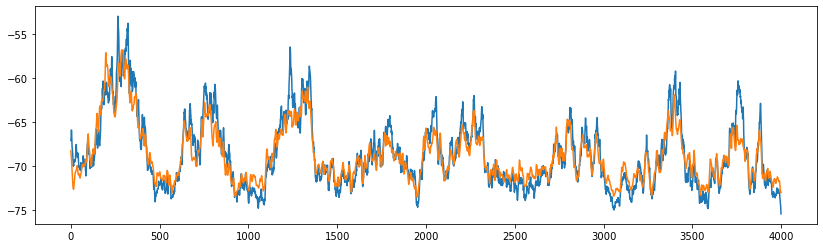

In [13]:
plt.figure(figsize=(14,4))
plt.plot(test_V_ref.cpu().detach().numpy()[:4000])
plt.plot(test_pred.cpu().detach().numpy()[:4000]+2.5)

In [14]:
for name, param in fit_shGLM.named_parameters():
    print(name, param.data)

V_o tensor([-77.9809], device='cuda:0')
K_syn tensor([[[-0.0028,  0.0458],
         [ 0.0065, -0.0809]],

        [[-0.1061,  0.1157],
         [ 0.2484, -0.2208]],

        [[-0.0777,  0.0798],
         [ 0.2527, -0.1495]],

        [[-0.0203,  0.0854],
         [ 0.1346, -0.1546]],

        [[-0.0911,  0.1310],
         [ 0.2599, -0.2860]]], device='cuda:0')
syn_basis_tau tensor([0.7401, 1.3488], device='cuda:0')
Delta tensor([5.0702], device='cuda:0')
C tensor([2.8267, 0.2062, 0.2771, 0.7619, 0.0914], device='cuda:0')
Theta tensor([2.4704, 0.5367, 0.9511, 0.2076, 0.5063], device='cuda:0')
thresh tensor([7.3540, 7.0921, 6.9248, 7.0124, 6.9437], device='cuda:0')
thresh_scale tensor([5.1495, 5.2494, 5.0335, 4.9874, 5.2066], device='cuda:0')
spike_size tensor([4.7894, 3.7822, 4.4629, 4.6193, 3.8413], device='cuda:0')
hist_basis_tau tensor([1.9864, 2.0841, 2.0602], device='cuda:0')
K_hist tensor([[0.2573, 0.2903, 0.4928],
        [0.7420, 0.9247, 0.9115],
        [0.7072, 0.8196, 1.0421]

# Test Params

In [4]:
final_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T)
final_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/final_fit/final5_spike5_s2_h3_shglm_i6100.pt"))

final_shGLM.eval().cuda()

V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
test_neural = torch.from_numpy(test_neural).float().cuda()

test_V_final = final_shGLM(test_neural).cpu().detach().numpy()

test_V_final = test_V_final
test_V_ref = test_V_ref

0.9532258482801599


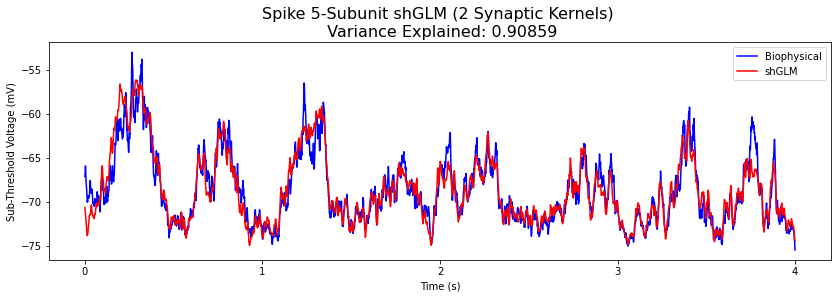

In [12]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[:4000], label="Biophysical", c="blue")
plt.plot(test_V_final[:4000]+0.1, label="shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("Spike 5-Subunit shGLM (2 Synaptic Kernels) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/shglm/biophysical/final5_spike5_s2_h3_shGLM.png", dpi=150, bbox_inches='tight')

In [5]:
for name, param in final_shGLM.named_parameters():
    print(name, param.data)

V_o tensor([-77.9947], device='cuda:0')
K_syn tensor([[[-0.0028,  0.0513],
         [ 0.0065, -0.0779]],

        [[-0.0944,  0.1204],
         [ 0.2424, -0.2011]],

        [[-0.0677,  0.0780],
         [ 0.2510, -0.1529]],

        [[-0.0177,  0.0994],
         [ 0.1339, -0.1494]],

        [[-0.0777,  0.1218],
         [ 0.2531, -0.2604]]], device='cuda:0')
syn_basis_tau tensor([0.8065, 1.3901], device='cuda:0')
Delta tensor([5.0683], device='cuda:0')
C tensor([2.8155, 0.2308, 0.2857, 0.7793, 0.0862], device='cuda:0')
Theta tensor([2.5289, 0.5196, 0.9802, 0.2333, 0.5037], device='cuda:0')
thresh tensor([7.3459, 7.1029, 6.9422, 7.0141, 6.9547], device='cuda:0')
thresh_scale tensor([5.1358, 5.2164, 5.0116, 4.9785, 5.1814], device='cuda:0')
spike_size tensor([4.7687, 3.8022, 4.4294, 4.6105, 3.8236], device='cuda:0')
hist_basis_tau tensor([2.0203, 2.1353, 2.1152], device='cuda:0')
K_hist tensor([[0.2513, 0.3018, 0.5003],
        [0.7128, 0.8963, 0.8831],
        [0.6878, 0.8034, 1.0254]